In [11]:
# Setup and Dependencies
!pip install pandas numpy matplotlib seaborn plotly -q

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

print("All libraries imported successfully!")
print(f"Pandas version: {pd.__version__}")

All libraries imported successfully!
Pandas version: 2.3.3


In [1]:
# Data Loading Class
class FreshwaterDataLoader:
    def __init__(self, filepath):
        self.filepath = filepath
        self.df = None
        self.df_long = None
        self.years = None
        
    def load_data(self):
        """Load the World Bank freshwater data"""
        try:
            # Read the CSV file
            self.df = pd.read_csv(self.filepath, skiprows=4)
            
            # Clean column names
            self.df.columns = [col.strip().replace('"', '') for col in self.df.columns]
            
            # Extract year columns
            self.years = [col for col in self.df.columns if col.isdigit()]
            
            # Create long format for analysis
            self.df_long = self.df.melt(
                id_vars=['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code'],
                value_vars=self.years,
                var_name='year',
                value_name='withdrawal_pct'
            )
            
            self.df_long['year'] = self.df_long['year'].astype(int)
            
            print(f"Data loaded successfully from: {self.filepath}")
            print(f"Total countries/regions: {self.df['Country Name'].nunique()}")
            print(f"Time span: {min(self.years)} - {max(self.years)}")
            print(f"Total data points: {len(self.df_long)}")
            
            return True
            
        except Exception as e:
            print(f"Error loading data: {e}")
            return False

# UPDATEING THE FILE PATH 
loader = FreshwaterDataLoader("API_ER.H2O.FWTL.ZS_DS2_en_csv_v2_4288.csv")
success = loader.load_data()

if success:
    # Showing a sample of the data
    print("\nSample of the data:")
    display(loader.df.head())
    
    print("\nSample of long format data:")
    display(loader.df_long.head())

Error loading data: name 'pd' is not defined


In [31]:
# Data Summary and Statistics
if success:
    print("DATA SUMMARY STATISTICS")
    print("="*50)
    
    # Statistics for recent years
    recent_years = ['2020', '2010', '2000', '1990', '1980']
    
    for year in recent_years:
        if year in loader.df.columns:
            data = loader.df[year].dropna()
            if len(data) > 0:
                print(f"\nYear {year}:")
                print(f"  Countries with data: {len(data)}")
                print(f"  Average withdrawal: {data.mean():.2f}%")
                print(f"  Median withdrawal: {data.median():.2f}%")
                print(f"  Min: {data.min():.2f}% | Max: {data.max():.2f}%")

DATA SUMMARY STATISTICS

Year 2020:
  Countries with data: 224
  Average withdrawal: 105.68%
  Median withdrawal: 8.64%
  Min: 0.02% | Max: 7750.00%

Year 2010:
  Countries with data: 175
  Average withdrawal: 130.56%
  Median withdrawal: 8.64%
  Min: 0.02% | Max: 7380.00%

Year 2000:
  Countries with data: 157
  Average withdrawal: 143.34%
  Median withdrawal: 8.61%
  Min: 0.02% | Max: 7218.41%

Year 1990:
  Countries with data: 103
  Average withdrawal: 148.87%
  Median withdrawal: 8.29%
  Min: 0.02% | Max: 5392.50%

Year 1980:
  Countries with data: 54
  Average withdrawal: 152.24%
  Median withdrawal: 25.31%
  Min: 0.06% | Max: 5011.67%


In [2]:
# Country Analysis Function
def analyze_country(country_name, df_long):
    """Analyze a specific country's freshwater withdrawal data"""
    country_data = df_long[df_long['Country Name'] == country_name].copy()
    
    if country_data.empty:
        print(f"No data found for {country_name}")
        return None
    
    # Filter out NaN values
    valid_data = country_data.dropna(subset=['withdrawal_pct'])
    
    if valid_data.empty:
        print(f"No valid data for {country_name}")
        return None
    
    print(f"\n{'='*60}")
    print(f"ANALYSIS FOR: {country_name}")
    print(f"{'='*60}")
    
    # Basic statistics
    print(f"\nBASIC STATISTICS:")
    print(f"• Data available for {len(valid_data)} years")
    print(f"• Time period: {valid_data['year'].min()} - {valid_data['year'].max()}")
    print(f"• Latest value ({valid_data['year'].max()}): {valid_data[valid_data['year'] == valid_data['year'].max()]['withdrawal_pct'].values[0]:.2f}%")
    print(f"• Minimum: {valid_data['withdrawal_pct'].min():.2f}%")
    print(f"• Maximum: {valid_data['withdrawal_pct'].max():.2f}%")
    print(f"• Average: {valid_data['withdrawal_pct'].mean():.2f}%")
    
    # Trend analysis
    if len(valid_data) > 1:
        sorted_data = valid_data.sort_values('year')
        first_value = sorted_data.iloc[0]['withdrawal_pct']
        last_value = sorted_data.iloc[-1]['withdrawal_pct']
        years_diff = sorted_data.iloc[-1]['year'] - sorted_data.iloc[0]['year']
        
        if years_diff > 0:
            total_change = ((last_value - first_value) / first_value * 100) if first_value != 0 else np.nan
            annual_change = total_change / years_diff if not np.isnan(total_change) else np.nan
            
            print(f"\nTREND ANALYSIS:")
            print(f"• Change from {sorted_data.iloc[0]['year']} to {sorted_data.iloc[-1]['year']}: {last_value - first_value:.2f}%")
            if not np.isnan(total_change):
                print(f"• Percentage change: {total_change:.1f}%")
                print(f"• Average annual change: {annual_change:.1f}%")
            
            # Classify trend
            if last_value > first_value + 5:
                print(f"• Trend: SIGNIFICANT INCREASE")
            elif last_value > first_value + 1:
                print(f"• Trend: ↗ MODERATE INCREASE")
            elif abs(last_value - first_value) < 1:
                print(f"• Trend: → STABLE")
            elif last_value < first_value - 5:
                print(f"• Trend: SIGNIFICANT DECREASE")
            else:
                print(f"• Trend: ↘ MODERATE DECREASE")
    
    # Water stress classification
    latest_value = valid_data[valid_data['year'] == valid_data['year'].max()]['withdrawal_pct'].values[0]
    print(f"\n WATER STRESS CLASSIFICATION:")
    if latest_value < 10:
        print(f"• Status: 🟢 LOW STRESS ({latest_value:.1f}%)")
    elif latest_value < 25:
        print(f"• Status: 🟡 MODERATE ({latest_value:.1f}%)")
    elif latest_value < 50:
        print(f"• Status: 🟠 MEDIUM-HIGH ({latest_value:.1f}%)")
    elif latest_value < 75:
        print(f"• Status: 🔴 HIGH STRESS ({latest_value:.1f}%)")
    elif latest_value < 100:
        print(f"• Status:  CRITICAL ({latest_value:.1f}%)")
    else:
        print(f"• Status: EXTREME (>100% - {latest_value:.1f}%)")
        print("  WARNING: Withdrawals exceed internal renewable resources!")
    
    return valid_data

# Test with a few countries
if success:
    test_countries = ['Botswana','South Africa','Zimbabwe','China', 'India', 'United States', 'Saudi Arabia', 'Canada']
    for country in test_countries:
        analyze_country(country, loader.df_long)
        print("\n")

In [3]:
# Visualization Functions
def plot_country_trend(country_names, df_long, start_year=1960, end_year=2024):
    """Plot withdrawal trends for multiple countries"""
    fig = go.Figure()
    
    colors = px.colors.qualitative.Set1
    
    for i, country in enumerate(country_names):
        country_data = df_long[df_long['Country Name'] == country].copy()
        country_data = country_data[
            (country_data['year'] >= start_year) & 
            (country_data['year'] <= end_year)
        ].dropna(subset=['withdrawal_pct'])
        
        if not country_data.empty:
            fig.add_trace(go.Scatter(
                x=country_data['year'],
                y=country_data['withdrawal_pct'],
                mode='lines+markers',
                name=country,
                line=dict(width=3, color=colors[i % len(colors)]),
                hovertemplate=f"{country}<br>Year: %{{x}}<br>Withdrawal: %{{y:.1f}}%"
            ))
    
    fig.update_layout(
        title=f'Freshwater Withdrawals Trend ({start_year}-{end_year})',
        xaxis_title='Year',
        yaxis_title='Withdrawal (% of Internal Resources)',
        hovermode='x unified',
        template='plotly_white',
        height=500,
        legend=dict(
            yanchor="top",
            y=0.99,
            xanchor="left",
            x=0.01
        )
    )
    
    # Adding horizontal reference lines
    fig.add_hline(y=100, line_dash="dash", line_color="red", 
                  annotation_text="100% Threshold", 
                  annotation_position="bottom right")
    fig.add_hline(y=25, line_dash="dot", line_color="orange", 
                  annotation_text="Moderate Stress", 
                  annotation_position="top right")
    
    return fig

def plot_country_comparison(country_names, year, df):
    """Create bar chart comparison for specific year"""
    year_data = []
    
    for country in country_names:
        value = df[df['Country Name'] == country][str(year)].values
        if len(value) > 0 and not pd.isna(value[0]):
            year_data.append({
                'country': country,
                'value': value[0]
            })
    
    if not year_data:
        print(f"No data available for year {year}")
        return None
    
    year_df = pd.DataFrame(year_data).sort_values('value', ascending=False)
    
    fig = px.bar(
        year_df, 
        x='value', 
        y='country',
        orientation='h',
        title=f'Freshwater Withdrawals Comparison ({year})',
        labels={'value': 'Withdrawal (%)', 'country': 'Country'},
        color='value',
        color_continuous_scale='Viridis'
    )
    
    fig.update_layout(height=400)
    return fig

# Create some visualizations
if success:
    print("CREATING VISUALIZATIONS")
    print("="*50)
    
    # Plot 1: Major countries trend
    fig1 = plot_country_trend(
        ['Botswana','South Africa','Zimbabwe','nigeria','China', 'India', 'United States', 'Russia', 'Germany'],
        loader.df_long,
        start_year=1990,
        end_year=2020
    )
    fig1.show()
    
    # Plot 2: Comparison for 2020
    fig2 = plot_country_comparison(
        ['Botswana','South Africa','Zimbabwe','nigeria','China', 'India', 'United States', 'Russia', 'Germany', 'Japan', 'France'],
        2020,
        loader.df
    )
    if fig2:
        fig2.show()


REGIONAL ANALYSIS: Arab, Botswana, Saudi, Emirates, Qatar, Kuwait
Countries in region: 8


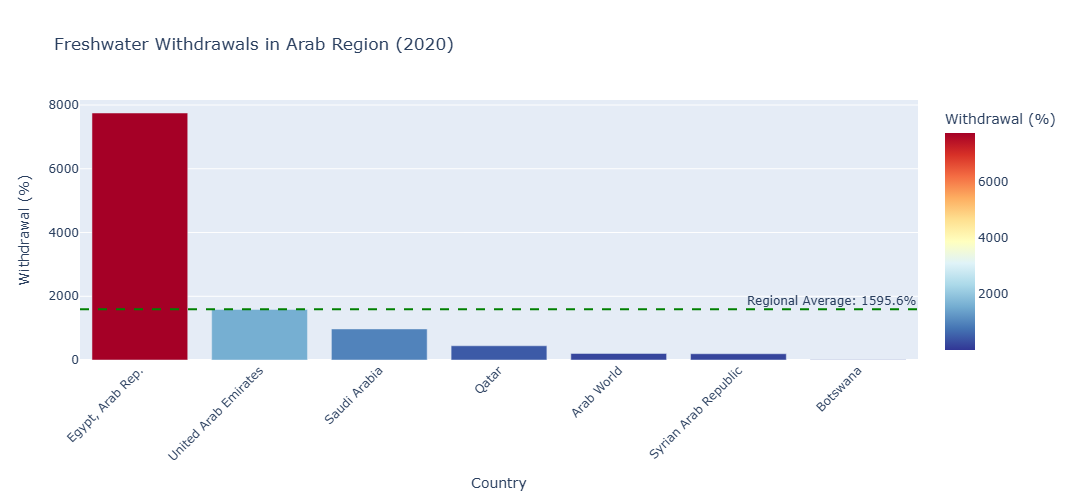


 MIDDLE EAST SUMMARY (2020):
• Number of countries: 7
• Regional average: 1595.6%
• Highest: Egypt, Arab Rep. (7750.0%)
• Lowest: Botswana (9.2%)


In [39]:
# Regional Analysis
def analyze_region(region_keywords, df_long, year=2020):
    """Analyze countries in a specific region"""
    # Find countries matching region keywords
    region_countries = []
    for country in df_long['Country Name'].unique():
        if any(keyword.lower() in country.lower() for keyword in region_keywords):
            region_countries.append(country)
    
    if not region_countries:
        print(f"No countries found for region: {region_keywords}")
        return None
    
    print(f"\nREGIONAL ANALYSIS: {', '.join(region_keywords)}")
    print(f"Countries in region: {len(region_countries)}")
    
    # Collect data for the region
    region_data = []
    for country in region_countries:
        country_data = df_long[
            (df_long['Country Name'] == country) & 
            (df_long['year'] == year)
        ]
        if not country_data.empty and not country_data['withdrawal_pct'].isna().all():
            value = country_data['withdrawal_pct'].values[0]
            region_data.append({
                'country': country,
                'value': value
            })
    
    if not region_data:
        print(f"No data available for year {year}")
        return None
    
    region_df = pd.DataFrame(region_data).sort_values('value', ascending=False)
    
    # Create visualization
    fig = px.bar(
        region_df,
        x='country',
        y='value',
        title=f'Freshwater Withdrawals in {region_keywords[0]} Region ({year})',
        labels={'value': 'Withdrawal (%)', 'country': 'Country'},
        color='value',
        color_continuous_scale='RdYlBu_r'
    )
    
    fig.update_layout(
        height=500,
        xaxis_tickangle=-45
    )
    
    # Add average line
    avg_value = region_df['value'].mean()
    fig.add_hline(
        y=avg_value,
        line_dash="dash",
        line_color="green",
        annotation_text=f"Regional Average: {avg_value:.1f}%",
        annotation_position="top right"
    )
    
    return fig, region_df

if success:
    # Analyze Middle East region
    fig_me, me_df = analyze_region(['Arab','Botswana', 'Saudi', 'Emirates', 'Qatar', 'Kuwait'], loader.df_long, 2020)
    if fig_me:
        fig_me.show()
        print("\n MIDDLE EAST SUMMARY (2020):")
        print(f"• Number of countries: {len(me_df)}")
        print(f"• Regional average: {me_df['value'].mean():.1f}%")
        print(f"• Highest: {me_df.iloc[0]['country']} ({me_df.iloc[0]['value']:.1f}%)")
        print(f"• Lowest: {me_df.iloc[-1]['country']} ({me_df.iloc[-1]['value']:.1f}%)")

In [40]:
# Interactive Exploration Tool
def interactive_explorer():
    """Interactive tool for exploring the data"""
    if not success:
        print("Please load the data first!")
        return
    
    print("INTERACTIVE DATA EXPLORER")
    print("="*50)
    print("Available functions:")
    print("1. analyze_country('Country Name') - Get detailed analysis")
    print("2. plot_country_trend(['Country1', 'Country2']) - Plot trends")
    print("3. find_extreme_cases(year, n=10) - Find extreme cases")
    print("4. analyze_region(['keyword1', 'keyword2'], year) - Regional analysis")
    print("\nExample: analyze_country('Germany')")
    
    # List all available countries
    all_countries = sorted(loader.df['Country Name'].unique())
    print(f"\n Total countries/regions available: {len(all_countries)}")
    
    # Show some examples
    print("\nExample countries to explore:")
    examples = ['Botswana','South Africa','Zimbabwe','nigeria''China', 'India', 'United States', 'Germany', 'Brazil', 
                'Egypt, Arab Rep.', 'Israel', 'Australia', 'Canada', 'Japan']
    for ex in examples:
        if ex in all_countries:
            print(f"  • {ex}")
    
    return all_countries

# Run the interactive explorer
available_countries = interactive_explorer()

INTERACTIVE DATA EXPLORER
Available functions:
1. analyze_country('Country Name') - Get detailed analysis
2. plot_country_trend(['Country1', 'Country2']) - Plot trends
3. find_extreme_cases(year, n=10) - Find extreme cases
4. analyze_region(['keyword1', 'keyword2'], year) - Regional analysis

Example: analyze_country('Germany')

 Total countries/regions available: 266

Example countries to explore:
  • Botswana
  • South Africa
  • Zimbabwe
  • India
  • United States
  • Germany
  • Brazil
  • Egypt, Arab Rep.
  • Israel
  • Australia
  • Canada
  • Japan


In [42]:
# Quick Analysis Examples
if success:
    print("\n QUICK ANALYSIS EXAMPLES")
    print("="*50)
    
    # Example 1: BRICS countries
    print("\n1. BRICS COUNTRIES ANALYSIS (2020):")
    brics = ['Brazil', 'Russia', 'India', 'China', 'South Africa']
    for country in brics:
        if country in loader.df['Country Name'].values:
            value = loader.df[loader.df['Country Name'] == country]['2020'].values
            if len(value) > 0 and not pd.isna(value[0]):
                print(f"   {country}: {value[0]:.1f}%")
    
    # Example 2: Water-stressed countries
    print("\n2. COUNTRIES WITH >100% WITHDRAWAL (2020):")
    high_stress = loader.df[loader.df['2020'] > 100]['Country Name'].tolist()
    for country in high_stress[:100]:  # Show first 10
        value = loader.df[loader.df['Country Name'] == country]['2020'].values[0]
        print(f"   {country}: {value:.1f}%")
    
    # Example 3: Countries with very low usage
    print("\n3. COUNTRIES WITH <1% WITHDRAWAL (2020):")
    low_usage = loader.df[loader.df['2020'] < 1]['Country Name'].tolist()
    for country in low_usage[:100]:  # Show first 10
        value = loader.df[loader.df['Country Name'] == country]['2020'].values[0]
        print(f"   {country}: {value:.2f}%")


🚀 QUICK ANALYSIS EXAMPLES

1. BRICS COUNTRIES ANALYSIS (2020):
   Brazil: 1.2%
   India: 44.8%
   China: 20.2%
   South Africa: 45.3%

2. COUNTRIES WITH >100% WITHDRAWAL (2020):
   Arab World: 206.2%
   United Arab Emirates: 1587.3%
   Azerbaijan: 150.4%
   Bahrain: 3877.5%
   Egypt, Arab Rep.: 7750.0%
   Iraq: 128.0%
   Israel: 170.1%
   Jordan: 140.4%
   Libya: 817.1%
   Middle East, North Africa, Afghanistan & Pakistan: 151.9%
   Middle East, North Africa, Afghanistan & Pakistan (excluding high income): 145.2%
   Mauritania: 337.1%
   Oman: 116.7%
   Pakistan: 344.7%
   Qatar: 446.4%
   Saudi Arabia: 974.2%
   Sudan: 673.4%
   Syrian Arab Republic: 195.8%
   Turkmenistan: 1868.0%
   Middle East, North Africa, Afghanistan & Pakistan (IDA & IBRD): 145.5%
   Uzbekistan: 306.0%
   Yemen, Rep.: 169.8%

3. COUNTRIES WITH <1% WITHDRAWAL (2020):
   Angola: 0.48%
   Bosnia and Herzegovina: 0.85%
   Belize: 0.66%
   Bolivia: 0.12%
   Bhutan: 0.43%
   Central African Republic: 0.05%
   Camero

In [44]:
# Data Export for Research
def export_for_research(loader, filename_prefix="freshwater_research"):
    """Export processed data for research purposes"""
    timestamp = pd.Timestamp.now().strftime("%Y%m%d_%H%M%S")
    
    # Export 1: Complete dataset in long format
    export_long = loader.df_long.copy()
    export_long.to_csv(f"{filename_prefix}_long_{timestamp}.csv", index=False)
    
    # Export 2: Country summaries
    summaries = []
    for country in loader.df['Country Name'].unique():
        country_data = loader.df_long[loader.df_long['Country Name'] == country]
        valid_data = country_data.dropna(subset=['withdrawal_pct'])
        
        if not valid_data.empty:
            summaries.append({
                'country': country,
                'country_code': country_data['Country Code'].iloc[0] if 'Country Code' in country_data.columns else '',
                'data_points': len(valid_data),
                'first_year': valid_data['year'].min(),
                'last_year': valid_data['year'].max(),
                'min_withdrawal': valid_data['withdrawal_pct'].min(),
                'max_withdrawal': valid_data['withdrawal_pct'].max(),
                'mean_withdrawal': valid_data['withdrawal_pct'].mean(),
                'latest_value': valid_data[valid_data['year'] == valid_data['year'].max()]['withdrawal_pct'].values[0] if not valid_data.empty else np.nan
            })
    
    summary_df = pd.DataFrame(summaries)
    summary_df.to_csv(f"{filename_prefix}_summary_{timestamp}.csv", index=False)
    
    # Export 3: Yearly statistics
    yearly_stats = []
    for year in range(1960, 2025):
        year_str = str(year)
        if year_str in loader.df.columns:
            data = loader.df[year_str].dropna()
            if len(data) > 0:
                yearly_stats.append({
                    'year': year,
                    'countries_with_data': len(data),
                    'mean': data.mean(),
                    'median': data.median(),
                    'std': data.std(),
                    'min': data.min(),
                    'max': data.max(),
                    'q25': data.quantile(0.25),
                    'q75': data.quantile(0.75)
                })
    
    yearly_df = pd.DataFrame(yearly_stats)
    yearly_df.to_csv(f"{filename_prefix}_yearly_{timestamp}.csv", index=False)
    
    print(f" Data exported successfully!")
    print(f" Files created:")
    print(f"  1. {filename_prefix}_long_{timestamp}.csv - Complete dataset")
    print(f"  2. {filename_prefix}_summary_{timestamp}.csv - Country summaries")
    print(f"  3. {filename_prefix}_yearly_{timestamp}.csv - Yearly statistics")
    
    return export_long, summary_df, yearly_df

# Export the data
if success:
    print("\n EXPORTING DATA FOR RESEARCH")
    print("="*50)
    long_data, summaries, yearly_stats = export_for_research(loader)
    
    # Show a preview of exported data
    print("\n Preview of exported summary data:")
    display(summaries.head())


 EXPORTING DATA FOR RESEARCH
 Data exported successfully!
 Files created:
  1. freshwater_research_long_20251224_070647.csv - Complete dataset
  2. freshwater_research_summary_20251224_070647.csv - Country summaries
  3. freshwater_research_yearly_20251224_070647.csv - Yearly statistics

 Preview of exported summary data:


,country,country_code,data_points,first_year,last_year,min_withdrawal,max_withdrawal,mean_withdrawal,latest_value
0,Africa Eastern and Southern,AFE,27,1995,2021,2.368021,5.041739,3.569002,5.041739
1,Afghanistan,AFG,48,1975,2022,22.693531,55.378791,43.225343,43.015907
2,Africa Western and Central,AFW,35,1987,2021,0.736782,1.707172,1.365897,1.705313
3,Angola,AGO,36,1987,2022,0.324324,0.476824,0.436141,0.476824
4,Albania,ALB,33,1990,2022,2.921933,6.831970,4.609789,2.962825


In [45]:
analyze_country('Botswana', loader.df_long)


ANALYSIS FOR: Botswana

BASIC STATISTICS:
• Data available for 38 years
• Time period: 1985 - 2022
• Latest value (2022): 8.89%
• Minimum: 3.75%
• Maximum: 9.73%
• Average: 7.09%

TREND ANALYSIS:
• Change from 1985 to 2022: 5.14%
• Percentage change: 137.0%
• Average annual change: 3.7%
• Trend: SIGNIFICANT INCREASE

 WATER STRESS CLASSIFICATION:
• Status: 🟢 LOW STRESS (8.9%)


,Country Name,Country Code,Indicator Name,Indicator Code,year,withdrawal_pct
6683,Botswana,BWA,"Annual freshwater withdrawals, total (% of int...",ER.H2O.FWTL.ZS,1985,3.750000
6949,Botswana,BWA,"Annual freshwater withdrawals, total (% of int...",ER.H2O.FWTL.ZS,1986,3.886667
7215,Botswana,BWA,"Annual freshwater withdrawals, total (% of int...",ER.H2O.FWTL.ZS,1987,4.023333
7481,Botswana,BWA,"Annual freshwater withdrawals, total (% of int...",ER.H2O.FWTL.ZS,1988,4.160000
7747,Botswana,BWA,"Annual freshwater withdrawals, total (% of int...",ER.H2O.FWTL.ZS,1989,4.296667
8013,Botswana,BWA,"Annual freshwater withdrawals, total (% of int...",ER.H2O.FWTL.ZS,1990,4.433333
8279,Botswana,BWA,"Annual freshwater withdrawals, total (% of int...",ER.H2O.FWTL.ZS,1991,4.570833
8545,Botswana,BWA,"Annual freshwater withdrawals, total (% of int...",ER.H2O.FWTL.ZS,1992,4.708333
8811,Botswana,BWA,"Annual freshwater withdrawals, total (% of int...",ER.H2O.FWTL.ZS,1993,5.130556
9077,Botswana,BWA,"Annual freshwater withdrawals, total (% of int...",ER.H2O.FWTL.ZS,1994,5.552778


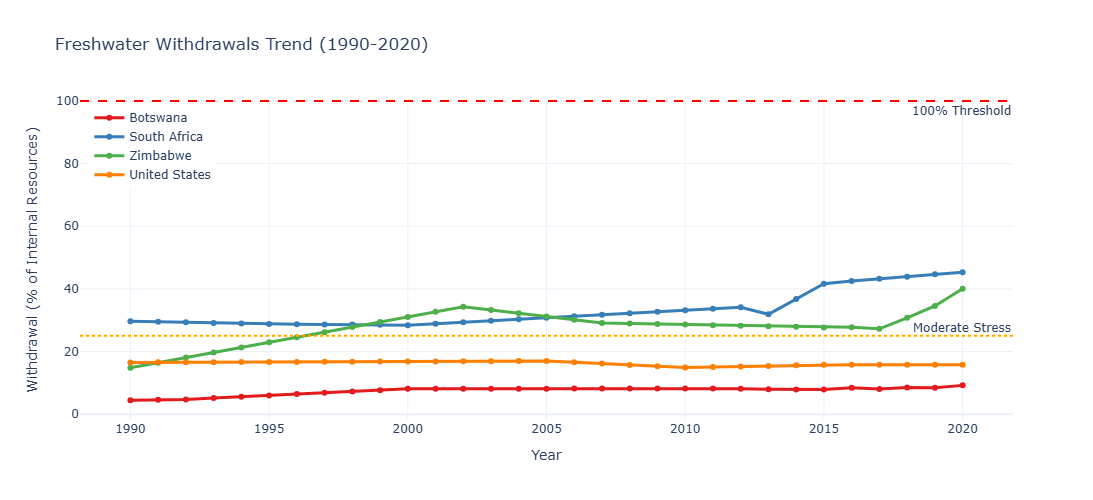

In [46]:
# Plot trends for multiple countries
fig = plot_country_trend(['Botswana','South Africa','Zimbabwe','nigeria', 'United States'], loader.df_long, 1990, 2020)
fig.show()